In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import sys
sys.path.append("src")

from energy_es.data import PricesManager
from energy_es.ui.tools import get_time

In [13]:
# Get prices
pm = PricesManager()
prices = pm.get_prices()

In [9]:
# Format date
dt = prices[0]["datetime"]
dt = dt.strftime(f"%a %b {dt.day} %Y (%Z)")
dt

'Mon Dec 5 2022 (UTC+01:00)'

In [10]:
# Create X axis values
x = list(map(lambda x: get_time(x["datetime"]), prices))
x = np.array(x)
x

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype='<U5')

In [11]:
# Create Y axis values
y = list(map(lambda x: x["value"], prices))
y = np.array(y)
y

array([220.69, 175.4 , 161.4 , 159.98, 157.  , 159.97, 162.17, 220.06,
       225.01, 226.14, 222.44, 221.61, 215.  , 217.6 , 221.71, 214.9 ,
       215.01, 221.61, 237.2 , 240.95, 245.58, 241.37, 226.55, 213.74])

In [14]:
# Minimum price
min_price = min(prices, key=lambda x: x["value"])
min_x = get_time(min_price["datetime"])
min_y = min_price["value"]
min_x, min_y

('04:00', 157)

In [15]:
# Maximum price
max_price = max(prices, key=lambda x: x["value"])
max_x = get_time(max_price["datetime"])
max_y = max_price["value"]
max_x, max_y

('20:00', 245.58)

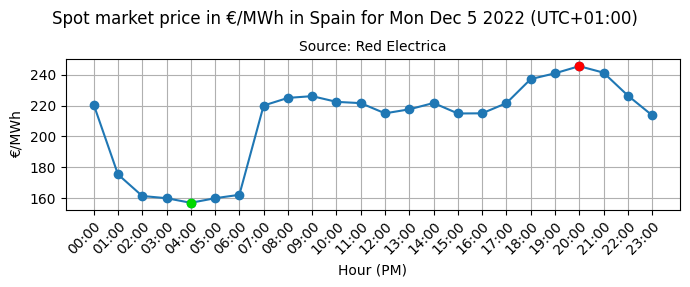

In [17]:
# Create chart
fig, ax = plt.subplots(figsize=(7, 3))
fig.suptitle(f"Spot market price in €/MWh in Spain for {dt}", y=0.94)

ax.set_title("Source: Red Electrica", fontdict={"fontsize": 10})
ax.plot(x, y, marker="o")
ax.scatter([min_x], [min_y], c="#00d800", zorder=2)
ax.scatter([max_x], [max_y], c="#ff0000", zorder=2)

ax.set(xlabel="Hour (PM)", ylabel="€/MWh")
ax.grid()

plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.show()